# Genetic Algorithm Tutorial with Python

#### Genetic Algorithm
* Genetic Algorithm을 이용한 variable selection은 자연 선택설과 포유류의 생식 프로세스와 유사하게 동작한다. Generation의 재생산을 반복하여 가장 우수한 solution을 찾는 것이 목적이다.

### 👍 장점

 - 기존 방법에 비해 빠르고 효율적임
 - 항상 문제에 대한 답변을 얻음
 - 검색 공간이 매우 크고 관련 매개 변수가 많은 경우에 유용함
 
### 👎 한계점

 - Fitness 값은 반복적으로 계산되므로 일부 문제의 경우 컴퓨팅 비용이 많이 듬
 - 확률적이므로 솔루션의 최적 또는 품질에 대한 보장이 없음
 - 제대로 구현되지 않으면 GA가 최적의 솔루션으로 수렴되지 않을 수 있음

#### 핵심 요소 3가지
 * `Selection` (선택) : solution의 quality를 높일 수 있는 후보군 찾기
 * `Crossover` (교배) : 앞 선 세대의 quality가 우수한 유전자들을 섞어 더 좋은 대안이 있는지 탐색
 * `Mutation` (돌연변이) : local optimum에서 빠져나와서 global optimum으로 갈 수 있는 기회를 만듦

#### 전체적인 절차는 다음과 같다.

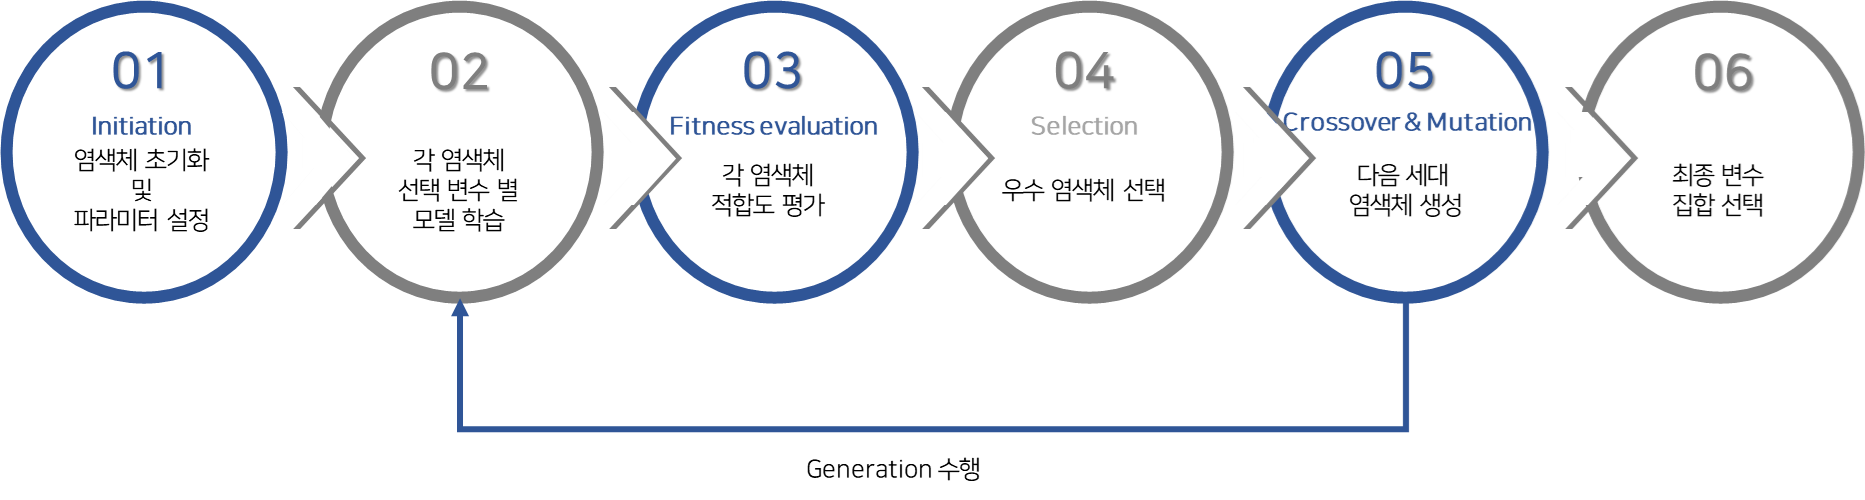

#### Dataset : Boston House Price dataset
 * Number of Instances : 506
 * Number of Attributes : 13
   * 데이터 설명
   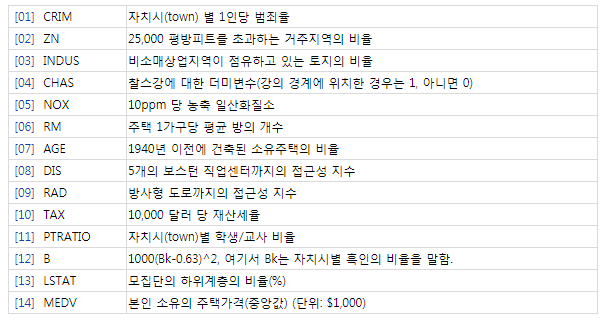
   
   이미지 출처 : http://dator.co.kr/?vid=ctg258&mid=textyle&document_srl=1721307

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import random
np.random.seed(42)


from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [180]:
# 데이터 불러오기
boston = load_boston()
# 데이터프레임 형태로 변환
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## 1️⃣ Step 1 : Initialization

#### Encoding Chromosomes
* Genetic algorithm은 variable selection에만 사용되는 것은 아니기 때문에 Encoding scheme는 task마다 달라질 수 있다.
* Variable selection에는 주로 binary encoding을 사용한다.

 * `chromosome`은 d차원의 binary vector를 의미하고
 * chromosome안의 각각의 변수들을 `gene`이라고 부른다.
 * 1이면 해당 변수를 모델링에 사용 / 0이면 해당 변수를 모델링에 사용하지 않는다.

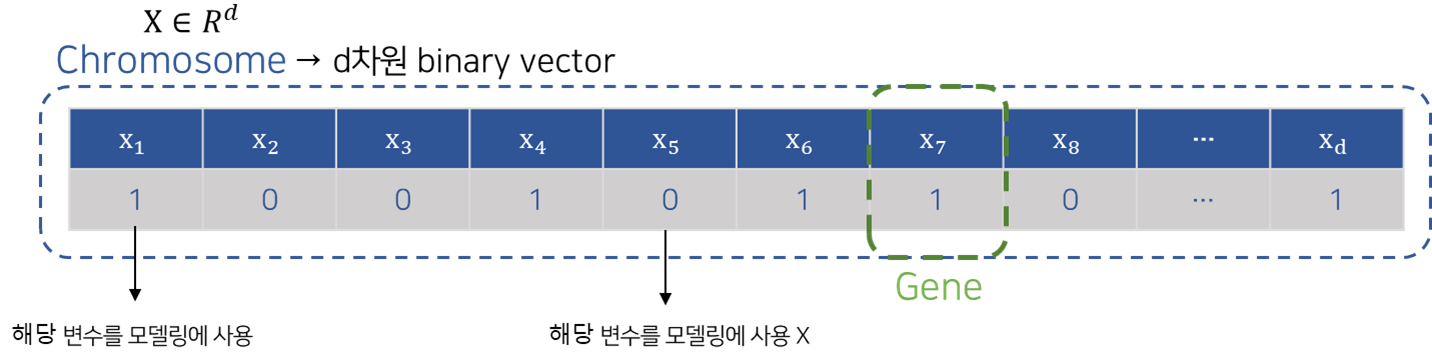

#### 각각의 gene에 random number(0과 1 사이의 값)를 부여

In [181]:
# 파라미터 설정
population=100 
cutoff=0.6

# 각 gene에 random number 부여
np.random.seed(42)
random_num = np.random.random_sample(size = (population,df.shape[1]))
rd_df = pd.DataFrame(random_num,columns=boston.feature_names)
rd_df   

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0.020584,0.969910,0.832443
1,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176
2,0.199674,0.514234,0.592415,0.046450,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233
3,0.440152,0.122038,0.495177,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,0.969585,0.775133
4,0.939499,0.894827,0.597900,0.921874,0.088493,0.195983,0.045227,0.325330,0.388677,0.271349,0.828738,0.356753,0.280935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.368526,0.864358,0.473210,0.968193,0.185526,0.868623,0.776597,0.770922,0.844783,0.761024,0.626220,0.131245,0.032526
96,0.920848,0.616650,0.796537,0.481522,0.117308,0.125186,0.685565,0.430306,0.200525,0.491595,0.064209,0.581971,0.268993
97,0.797559,0.310362,0.455220,0.011621,0.072447,0.392494,0.479939,0.600021,0.291663,0.694982,0.860122,0.779851,0.039619
98,0.480507,0.104930,0.242045,0.986663,0.142496,0.498888,0.618156,0.702465,0.559649,0.009771,0.326461,0.517712,0.087866


#### Cut-off를 기준으로 Random number를 binary value로 변환

In [182]:
# cut-off 기준으로 random number를 binary values로 변환 (0.5미만이면 0, 이상이면 1)
binary_df = rd_df.applymap(lambda row : 0  if row < cutoff else 1 )
binary_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0,1,1,0,0,0,0,1,1,1,0,1,1
1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1,1,1,0,0,1
3,0,0,0,0,1,0,1,0,0,0,0,1,1
4,1,1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,1,0,1,1,1,1,1,1,0,0
96,1,1,1,0,0,0,1,0,0,0,0,0,0
97,1,0,0,0,0,0,0,1,0,1,1,1,0
98,0,0,0,1,0,0,1,1,0,0,0,0,0


## 2️⃣ Step 2 : Train the model

* Multivariate linear regression (MLP)라고 가정한다.
 * Chromosome 0  :              $𝑦 ̂=𝐵 ̂_0+𝐵 ̂_2 𝑥_2 + 𝐵 ̂_3 𝑥_3 + 𝐵 ̂_4 𝑥_4 + 𝐵 ̂_8 𝑥_8 + 𝐵 ̂_9 𝑥_9 + 𝐵 ̂_{10} 𝑥_{10} + 𝐵 ̂_{12} 𝑥_{12} + 𝐵 ̂_{13} 𝑥_{13}$
 * Chromosome 1  :              $𝑦 ̂=𝐵 ̂_0+𝐵 ̂_5 𝑥_5+ + 𝐵 ̂_8 𝑥_8 + 𝐵 ̂_{13} 𝑥_{13}$
 *  ⋯

 위와 같은 방식으로 총 10개의 MLR을 학습한다.


In [183]:
# 모델
model = LinearRegression()
r2_list = []

# adjusted R^2 
def score_fn(r2, n, p):
    return 1 - (1-r2)*(n-1)/(n-p-1)


for idx in binary_df.index:
    # binary value로 변환한 데이터프레임에서 값이 1인 변수만 모델링에 사용
    col = binary_df.loc[idx][binary_df.loc[idx]==1].index.tolist()
    features = df[col]
    print(features.columns)
    
    
    # target data
    target = boston.target
    
    #train과 test set 나누기
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.2)
    model.fit(X_train,y_train) # 모델 학습
    y_pred = model.predict(X_test) # 예측
    
    # fitness function : adjusted R^2
    r2 = r2_score(y_test, y_pred)
    adj_r2 = score_fn(r2, len(X_test), X_test.shape[1])
    r2_list.append(adj_r2)
    
    
r2_list 

Index(['ZN', 'INDUS', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT'], dtype='object')
Index(['DIS', 'LSTAT'], dtype='object')
Index(['NOX', 'DIS', 'RAD', 'TAX', 'LSTAT'], dtype='object')
Index(['NOX', 'AGE', 'B', 'LSTAT'], dtype='object')
Index(['CRIM', 'ZN', 'CHAS', 'PTRATIO'], dtype='object')
Index(['INDUS', 'NOX', 'RM', 'RAD', 'TAX', 'PTRATIO', 'B'], dtype='object')
Index(['INDUS', 'CHAS', 'RAD', 'TAX', 'PTRATIO'], dtype='object')
Index(['CRIM', 'ZN', 'CHAS', 'PTRATIO'], dtype='object')
Index(['CRIM', 'CHAS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='object')
Index(['ZN', 'CHAS', 'NOX', 'TAX', 'PTRATIO'], dtype='object')
Index(['NOX', 'DIS', 'TAX', 'PTRATIO'], dtype='object')
Index(['CHAS', 'DIS', 'B'], dtype='object')
Index(['CRIM', 'ZN', 'CHAS', 'RM', 'AGE', 'TAX'], dtype='object')
Index(['ZN', 'RM', 'DIS', 'TAX'], dtype='object')
Index(['CRIM', 'ZN', 'CHAS', 'NOX', 'TAX', 'PTRATIO', 'B'], dtype='object')
Index(['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'RAD', 'TAX', 'LSTAT'], dtype='object')


[0.581747389598851,
 0.5393402635334124,
 0.48418530845009167,
 0.5813741058931952,
 0.38435016914898035,
 0.5506245117718216,
 0.3820752731422008,
 0.33391277946477615,
 0.6166790249766505,
 0.4282812758632337,
 0.5110009031199659,
 0.1873160455052716,
 0.5232500879336759,
 0.668397037214427,
 0.3091525544827113,
 0.6890302923781076,
 0.5283891409412491,
 0.39010452712215016,
 0.3024479073854479,
 0.6105815829052135,
 0.747080316849947,
 0.3916166867460731,
 0.6164960047984644,
 0.7073242167026363,
 0.5803533286687345,
 0.49265325682052263,
 0.11741850694056477,
 0.5799410400668725,
 0.5130803042878096,
 0.6015051497734095,
 0.6902040894625644,
 0.4946172051730968,
 0.3709333131962884,
 0.6192553568998491,
 0.6066339007096166,
 0.4893421101467452,
 0.7844411456447407,
 0.4853756260459057,
 0.6845023511132791,
 0.7749028180948541,
 0.5777480348315827,
 0.3494347260035341,
 0.7214490194271845,
 0.5183795393020411,
 0.577037956029586,
 0.2963563582196441,
 0.1167913412603252,
 0.27910063

## 3️⃣ Step 3 : Fitness Evaluation

* 어떤 chromosome이 더 좋은가를 평가하는 기준 &rarr; Fitness values가 높을 수록 좋은 chromosomes

* Common criteria
 * 두 개의 chromosome이 같은 성능을 보인다면, 변수의 개수가 더 적은 것을 선호한다.
 * 두 chromosome 변수의 개수가 같다면, 더 높은 예측 성능을 가진 것을 선호한다.

* 지금은 Adjusted $𝑅^2$을 fitness function으로 설정

In [184]:
# Chromosome selection시 weight 사용
weight = [x/sum(r2_list) for x in r2_list] # 각 adjusted R^2값에 sum(adjusted R^2)을 나눠준 것
fitness_df = pd.DataFrame(list(zip(r2_list,weight)), columns = ['Adj R^2', 'Weight'])
fitness_df             

,Adj R^2,Weight
0,0.581747,0.012257
1,0.539340,0.011364
2,0.484185,0.010202
3,0.581374,0.012249
4,0.384350,0.008098
...,...,...
95,0.471244,0.009929
96,0.164985,0.003476
97,0.206546,0.004352
98,0.152958,0.003223


In [185]:
# Rank 구하기
fitness_df['Rank'] =fitness_df['Weight'].rank(ascending=False)
fitness_df

,Adj R^2,Weight,Rank
0,0.581747,0.012257,33.0
1,0.539340,0.011364,44.0
2,0.484185,0.010202,60.0
3,0.581374,0.012249,34.0
4,0.384350,0.008098,69.0
...,...,...,...
95,0.471244,0.009929,62.0
96,0.164985,0.003476,92.0
97,0.206546,0.004352,87.0
98,0.152958,0.003223,94.0


## 4️⃣ Step 4 : Selection
현재 population 중 우수한 chromosome 선택하여 다음 세대의 population을 생산하는 과정

### Deterministic selection
* 상위 N%의 chromosome만 선택되고 그 밑은 폐기하는 방법

### Probabilistic selection
* 모든 chromosome에게 유전자를 넘겨줄 수 있는 기회를 주는 방법
* Fitness values가 높았던 chromosome이 높은 확률로 select된다.

해당 예시에서는 `Deterministic selection` 방법을 선택

In [186]:
selection_N = 0.5
# 상위 50%만 선택
selection1 = binary_df.loc[fitness_df.sort_values(by="Rank")[:int(len(fitness_df)* selection_N)].index]
selection1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
36,0,1,0,1,0,1,0,1,0,0,1,0,1
77,0,1,1,1,1,1,1,0,0,0,1,1,0
39,1,1,1,1,0,1,1,0,0,0,1,1,0
20,1,1,0,0,1,1,1,1,0,0,1,1,1
42,0,1,0,1,0,1,0,0,1,0,0,0,1
61,1,0,1,1,0,1,1,1,0,0,1,0,1
23,0,0,0,0,1,1,1,0,0,1,0,0,0
83,1,1,0,0,1,1,0,1,0,1,0,1,1
30,1,0,0,1,0,1,1,0,1,1,0,1,0
15,0,1,1,1,1,1,0,0,1,1,0,0,1


## 5️⃣ Step 5 : Crossover & Mutation

### 1) Crossover
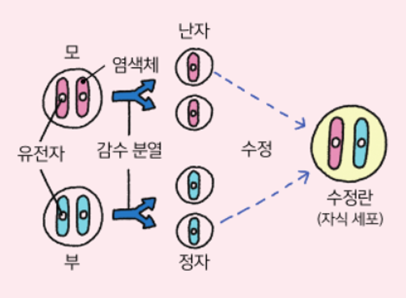
    사진 출처 : https://post.naver.com/viewer/postView.nhn?volumeNo=22462557&memberNo=1474987
* 부모 양쪽으로부터 유전자를 반 씩 물려받아 다양한 조합으로 자식세포가 생성되는 것과 동일하게 부모 chromosome에서 절반씩 가져와서 자식 chromosome 만드는 과정
* `Crossover point` : 부모 chromosome의 어느 지점에서 가져올지 설정 (1개~gene의 총 개수)

In [187]:
# 앞서 구한 상위 50%의 chromosome 중에서 랜덤으로 두 개를 선택 => 부모 choromosome
selection1 = selection1.sample(n=2, random_state=42)
selection1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
62,1,1,0,0,1,1,0,1,1,0,0,0,0
94,0,1,0,1,0,0,1,0,1,0,0,0,1


### 1-1) Single Point Crossover Operator : crossover point가 1인 경우
* 예시 그림
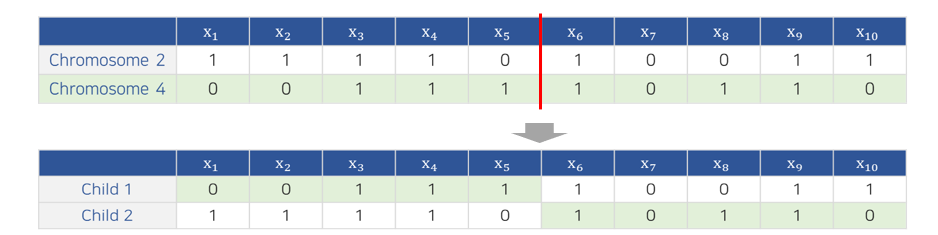

In [188]:
def single_point_crossover(df, crossover_idx) :
    parents1 = df.iloc[0,:]
    parents2 = df.iloc[1,:]
    child1 = list(parents2[:crossover_idx]) + list(parents1[crossover_idx:])
    child2 = list(parents1[:crossover_idx]) + list(parents2[crossover_idx:])
    return child1, child2

In [189]:
sigle_point_child_df = pd.DataFrame(single_point_crossover(selection1,4),columns=selection1.columns, index =['child1','child2'])
sigle_point_child_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
child1,0,1,0,1,1,1,0,1,1,0,0,0,0
child2,1,1,0,0,0,0,1,0,1,0,0,0,1


### 1-2) Multi-Point Crossover Operator : crossover point가 2개 이상인 경우
* 예시 그림 (crossover point = 2)
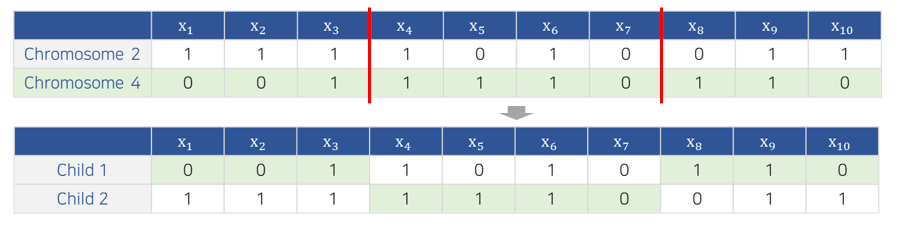

In [190]:
def multi_point_crossover(df, crossover_idx_list) :
    for i in crossover_idx_list :
        child1, child2 = single_point_crossover(df, i)
        df= pd.DataFrame([child1, child2],columns=selection1.columns, index =['child1','child2'])
    return child1, child2

In [191]:
multi_point_child_df = pd.DataFrame(multi_point_crossover(selection1,[4,8,11]),columns=selection1.columns, index =['child1','child2'])
multi_point_child_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
child1,0,1,0,1,1,1,0,1,1,0,0,0,0
child2,1,1,0,0,0,0,1,0,1,0,0,0,1


### 1-3) Uniform Crossover Operator : random number 생성한 후 threshold보다 큰 것만 crossover
* 예시 그림 (threshold = 0.5)
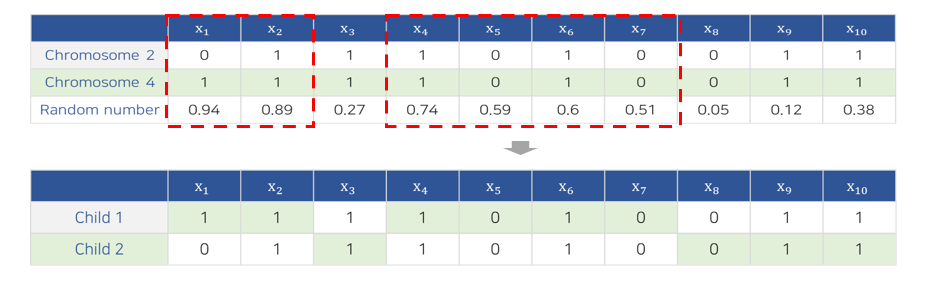

In [192]:
def uniform_crossover(df, threshold):
    parents1 = df.iloc[0,:]
    parents2 = df.iloc[1,:]
    random_num= np.random.random_sample(df.shape[1])
    for i in range(len(random_num)) :
        if random_num[i] < 0.5 :
            temp = parents1[i]
            parents1[i] = parents2[i]
            parents2[i] = temp
        child1, child2 = parents1, parents2
    return child1, child2

In [193]:
uniform_child_df = pd.DataFrame(uniform_crossover(selection1,0.5),columns=selection1.columns, index =['child1','chld2'])
uniform_child_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
child1,1,1,0,1,0,0,1,1,1,0,0,0,1
chld2,0,1,0,0,1,1,0,0,1,0,0,0,0


### 2) Mutation

* 목적 : Local optimum에 빠질 수 있는 위험을 제거하고 탈출 할 수 있는 기회를 준다.
* ❗ 주의할 점 : 너무 큰 mutation rate를 사용하면 수렴하는 데 시간이 오래 걸린다. (`0.01` 정도가 좋다고 한다.) &rarr; 이 예시에서는 0.05으로 지정하였다.


In [194]:
mutation_rate = 0.05

In [195]:
# Crossover을 통해 만들어진 Child에 random number 생성
n_list =[]
for i in [0,1]:
    for j in range(multi_point_child_df.shape[1]):
        n = np.random.random_sample()
        n_list.append(n)
        if n <= mutation_rate :
            if multi_point_child_df.iloc[i,:][j] == 1 : 
                multi_point_child_df.iloc[i,:][j] = 0   # Random number가 mutation_rate보다 작은 변수의 값을 1에서 0으로 변경

            else : multi_point_child_df.iloc[i,:][j] = 1   # Random number가 mutation_rate보다 작은 변수의 값을 0에서 1로 변경
        else : 
            pass
        j+=1
    i+=1  

In [196]:
# 생성된 random number 확인 -> 데이터프레임
n_df =pd.DataFrame([n_list[:13],n_list[13:]],columns=multi_point_child_df.columns,index=['Random number1','Random number2'])
n_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
Random number1,0.421496,0.419321,0.859901,0.993827,0.825896,0.558118,0.097366,0.954484,0.860046,0.841411,0.391818,0.447171,0.119662
Random number2,0.937873,0.943234,0.254441,0.696008,0.203490,0.392947,0.302381,0.389591,0.308973,0.345291,0.791060,0.300027,0.814695


In [197]:
# mutation 후의 child chromosome
multi_point_child_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
child1,0,1,0,1,1,1,0,1,1,0,0,0,0
child2,1,1,0,0,0,0,1,0,1,0,0,0,1


* mutation_rate보다 작은 값이 존재하지 않으므로 변화가 없다.

### child chromosome으로 모델링하고 성능확인하기

In [198]:
child_r2_list=[]
for idx in multi_point_child_df.index:
    col = multi_point_child_df.loc[idx][multi_point_child_df.loc[idx]==1].index.tolist()
    
    features = df[col]
    print(features.columns)
    target = boston.target
    
    X_train1, X_test1, y_train1, y_test1 = train_test_split(features,target, test_size = 0.2)
    model.fit(X_train1,y_train1)
    y_pred2 = model.predict(X_test1)
    
    r2 = r2_score(y_test1, y_pred2)
    adj_r2 = score_fn(r2, len(X_test1), X_test1.shape[1])
    child_r2_list.append(adj_r2)
    
    
child_r2_list 

Index(['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD'], dtype='object')
Index(['CRIM', 'ZN', 'AGE', 'RAD', 'LSTAT'], dtype='object')


[0.4388729431368479, 0.5386600793468739]

### 여기까지 한 번의 generation이고, 종료조건을 만족할 때까지 generation을 반복한다.

In [199]:
# Genetic Algorithm 
def GA(df, target, binary_df, selection_N = 0.4, single_point=True, mutation_rate = 0.03):  
       
    # Step 2
    model = LinearRegression()
    r2_list = []

    # adjusted R^2 
    def score_fn(r2, n, p):
        return 1 - (1-r2)*(n-1)/(n-p-1)

    for idx in binary_df.index:
       
        col = binary_df.loc[idx][binary_df.loc[idx]==1].index.tolist()

        features = df[col]
        target = target

        X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.2)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        adj_r2 = score_fn(r2, len(X_test), X_test.shape[1])
        r2_list.append(adj_r2)

    # Step 3
    weight = [x/sum(r2_list) for x in r2_list]
    fitness_df = pd.DataFrame(list(zip(r2_list,weight)), columns = ['Adj R^2', 'Weight'])
    fitness_df['Rank'] =fitness_df['Weight'].rank(ascending=False)

    # Step 4
    # 상위 50%만 선택
    selection1 = binary_df.loc[fitness_df.sort_values(by="Rank")[:int(len(fitness_df)* selection_N)].index]
    best_score = fitness_df.sort_values(by="Rank")['Adj R^2'].max()
    
    arg = np.array(binary_df.iloc[fitness_df['Weight'].argmax()].tolist())
    idx_max = np.where(arg==1)[0].tolist()
    best_subset = df.loc[idx_max].columns.tolist()


    # Step 5
    
    # Crossover
    df_null = pd.DataFrame(columns=selection1.columns)
    for i in range(int(population/2)):
        selection1 = selection1.sample(n=2)
        # 앞서 구한 상위 50%의 chromosome 중에서 랜덤으로 두 개를 선택 => 부모 choromosome
        if single_point== True :
            crossover_point = np.random.choice(range(1, selection1.shape[1]), 1, replace=False)[0]
            child_df = pd.DataFrame(single_point_crossover(selection1,crossover_point),columns=selection1.columns)
        else:
            crossover_point = sorted(np.random.choice(range(1, selection1.shape[1]), crossover_point, replace=False))
            child_df = pd.DataFrame(multi_point_crossover(selection1,crossover_point),columns=selection1.columns)
        df_null=df_null.append(child_df)

    child_df = df_null.reset_index(drop=True)
    
    # Mutation
    n_list =[]
    for i in range(len(child_df)):
        for j in range(child_df.shape[1]):
            n = np.random.random_sample()
            n_list.append(n)
            if n <= mutation_rate :
                if child_df.iloc[i,:][j] == 1 :
                    child_df.iloc[i,:][j] = 0
                else : child_df.iloc[i,:][j] = 1
            else : 
                pass
            j+=1
        i+=1  
                
    return best_score, best_subset, child_df      
    
    

### generation 반복

In [200]:
# 파라미터 설정
population= 100 # 한 세대에서 고려하는 chromosome 개수
cutoff= 0.6 
max_iteration= 30  # 최대 generation 수
selection_N = 0.3  # deterministic selection시, 상위 N%까지 선택
mutation_rate = 0.03  # 돌연변이율

# Step 1
np.random.seed(42)
random_num = np.random.random_sample(size = (population,df.shape[1]))
rd_df = pd.DataFrame(random_num,columns=df.columns)
binary_df =rd_df.applymap(lambda row : 0  if row < cutoff else 1 )

In [201]:
best_score_list = [] # 각 generation별 best score
best_subset_list = []  # 각 generation별 best score를 가지는 변수 조합

for i in range(max_iteration):
    best_score, best_subset, binary_df = GA(df, target, binary_df, selection_N , single_point=True, mutation_rate = 0.03)
    best_score_list.append(best_score)
    best_subset_list.append(best_subset)
    print('Iteration {}: Best Score = {}'. format(i, best_score))
print('-------------------------------------------------------------')
best_idx =best_score_list.index(max(best_score_list))   
print('Final Best Score(Iteration {}) = {}, \nBest Subset = {}'. format(best_idx, max(best_score_list), best_subset_list[best_idx]))

Iteration 0: Best Score = 0.7844411456447407
Iteration 1: Best Score = 0.745749406866296
Iteration 2: Best Score = 0.7896950542000858
Iteration 3: Best Score = 0.7809536660297541
Iteration 4: Best Score = 0.7792329839967443
Iteration 5: Best Score = 0.8074583356427314
Iteration 6: Best Score = 0.7772110217705104
Iteration 7: Best Score = 0.7615844399384332
Iteration 8: Best Score = 0.8064448275342109
Iteration 9: Best Score = 0.7742653885373577
Iteration 10: Best Score = 0.7830326495999137
Iteration 11: Best Score = 0.8042408191969868
Iteration 12: Best Score = 0.7832208944859206
Iteration 13: Best Score = 0.7713625155674804
Iteration 14: Best Score = 0.7956594590445867
Iteration 15: Best Score = 0.8088454748113545
Iteration 16: Best Score = 0.8064177437493352
Iteration 17: Best Score = 0.8059681792067518
Iteration 18: Best Score = 0.7951203966296868
Iteration 19: Best Score = 0.8188576901138157
Iteration 20: Best Score = 0.8047504294071947
Iteration 21: Best Score = 0.8051967484502138

<function matplotlib.pyplot.show(close=None, block=None)>

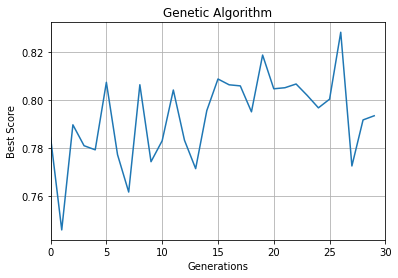

In [202]:
# 그래프 그리기
plt.plot(best_score_list)
plt.xlim(0, 30)
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Genetic Algorithm')
plt.grid(True)
plt.show

### <결론>
* Generation을 지나면서 성능이 점차 증가한다. 하지만 종료조건에 따라 최종적인 변수 집합이 많이 달라질 것으로 보인다.
* Population을 10에서 100으로 늘리니 성능이 증가하였다. Population을 크게 설정할수록 넓은 범위를 탐색할 수 있기 때문.

## Reference
* https://jeongchul.tistory.com/571
* [보스턴 주택 가격 데이터셋 소개](https://wikidocs.net/49966)
* [Crossover Operator — The Heart of Genetic Algorithm](https://medium.com/@samiran.bera/crossover-operator-the-heart-of-genetic-algorithm-6c0fdcb405c0)
* [Pilsung Kang (2022) IME654: Business Analytics, Lecture 01. Dimensionality Reduction: Genetic Algorithm, Korea University.](https://github.com/pilsung-kang/Business-Analytics-IME654-/blob/master/01%20Dimensionality%20Reduction/01_3_Dimensionality%20Reduction_GA.pdf)